In [14]:
import pandas as pd

# ---- file name ----
filename = "69778494.par"


In [15]:
import pandas as pd
import re

filename = "69778494.par"

# HITRAN fixed-width columns (matched to your file)
colspecs = [
    (0, 2),      # Molecule ID
    (2, 3),      # Isotopologue
    (3, 15),     # Wavenumber (cm-1)
    (15, 25),    # Line intensity (296 K)
    (73, 90),    # Upper vibrational QNs
    (90, 107),   # Lower vibrational QNs
    (107, 125),  # Local quantum numbers
]

cols = ["mol", "iso", "nu", "intensity", "vib_up", "vib_lo", "local_qn"]

df = pd.read_fwf(filename, colspecs=colspecs, names=cols)


df = pd.read_fwf(filename, colspecs=colspecs, names=cols)

# strip whitespace
for c in ["vib_up", "vib_lo", "local_qn"]:
    df[c] = df[c].astype(str).str.strip()

# parse vibrational states
def parse_vib(s):
    parts = s.split()
    if len(parts) >= 4:
        return tuple(int(p) for p in parts[:4])
    return None

df["up"] = df["vib_up"].apply(parse_vib)
df["lo"] = df["vib_lo"].apply(parse_vib)

# ---- ν2 fundamental filter ----
df = df[
    (df["up"] == (0, 1, 1, 0)) &
    (df["lo"] == (0, 0, 0, 0))
]

# ---- extract branch, J'', parity ----
def parse_branch(s):
    """
    Matches strings like:
    'P  2e', 'Q 15f', 'R 27e'
    """
    m = re.search(r'([PQR])\s*(\d+)\s*([ef])', s)
    if m:
        return m.group(1), int(m.group(2)), m.group(3)
    return None, None, None

df[["branch", "Jpp", "parity"]] = df["local_qn"].apply(
    lambda s: pd.Series(parse_branch(s))
)

# sort nicely
df = df.sort_values(["branch", "Jpp"])

print(f"Found {len(df)} ν2 (0110→0000) transitions")

# save
df.to_csv("HCN_v2_0110_0000_with_branch.csv", index=False)


Found 188 ν2 (0110→0000) transitions


In [16]:
df.loc[(df["branch"] == "R") & (df["Jpp"] == 22), ["nu", "intensity"]]


,nu,intensity
10367,779.726066,2.392000e-20


In [17]:
min(df['nu'])
max(df['nu'])

896.98283

In [18]:
# # assume df is your filtered dataframe already

# # select P and Q branches
# pq = df[df["branch"].isin(["P", "Q"])]

# # take first 23 of each branch (sorted by J'')
# pq_23 = (
#     pq.sort_values(["branch", "Jpp"])
#       .groupby("branch")
#       .head(26)
# )

# # print line by line
# for _, row in pq_23.iterrows():
#     print(
#         f"branch={row['branch']:<2} "
#         f"J''={row['Jpp']:<2} "
#         f"parity={row['parity']}  "
#         f"nu={row['nu']:.6f}  "
#         f"v_up={row['up']}  "
#         f"v_lo={row['lo']}  "
#         f"E_low={row['E_lower'] if 'E_lower' in row else 'N/A'}"
#     )


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = "HCN_LinesPQR_improved.txt"

# ---- read file as raw whitespace table ----
df_pg = pd.read_csv(
    filename,
    delim_whitespace=True,
    engine="python",
    skiprows=1,
    header=None
)
# ---- assign only the columns we care about ----
# Based on PGOPHER format:
# col 10 -> Position
# col 11 -> Intensity
# col 17 -> Branch
# col16 -> Branch line type (P, Q, R)

df_pg = df_pg[[9, 10, 16, 17]]
df_pg.columns = ["Position", "Intensity", "BranchLine", "Branch"]

# ---- convert numerics ----
df_pg["Position"] = pd.to_numeric(df_pg["Position"], errors="coerce")
df_pg["Intensity"] = pd.to_numeric(df_pg["Intensity"], errors="coerce")

# drop any bad rows
df_pg = df_pg.dropna()



/var/folders/m_/lkkr9ssx3_l8p4_6mmy0fsym0000gn/T/ipykernel_21889/960234622.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_pg = pd.read_csv(


In [20]:
# extract branch letter and J from strings like "Q(19)"
df_pg["branch"] = df_pg["BranchLine"].str[0]
df_pg["Jpp"] = (
    df_pg["BranchLine"]
    .str.extract(r"\((\d+)\)")
    .astype(int)
)

df_pg = df_pg[
    (df_pg["branch"] != "Q") |
    ((df_pg["branch"] == "Q") & (df_pg["Jpp"] <= 18))
]


In [21]:
# ---- normalize intensities ----
I_pg = df_pg["Intensity"].values
I_hit = df["intensity"].values

I_pg_norm  = I_pg  / I_pg.max()
I_hit_norm = I_hit / I_hit.max()



/var/folders/m_/lkkr9ssx3_l8p4_6mmy0fsym0000gn/T/ipykernel_21889/1048744175.py:124: RuntimeWarning: divide by zero encountered in divide
  return 1e4 / nu
/var/folders/m_/lkkr9ssx3_l8p4_6mmy0fsym0000gn/T/ipykernel_21889/1048744175.py:124: RuntimeWarning: divide by zero encountered in divide
  return 1e4 / nu


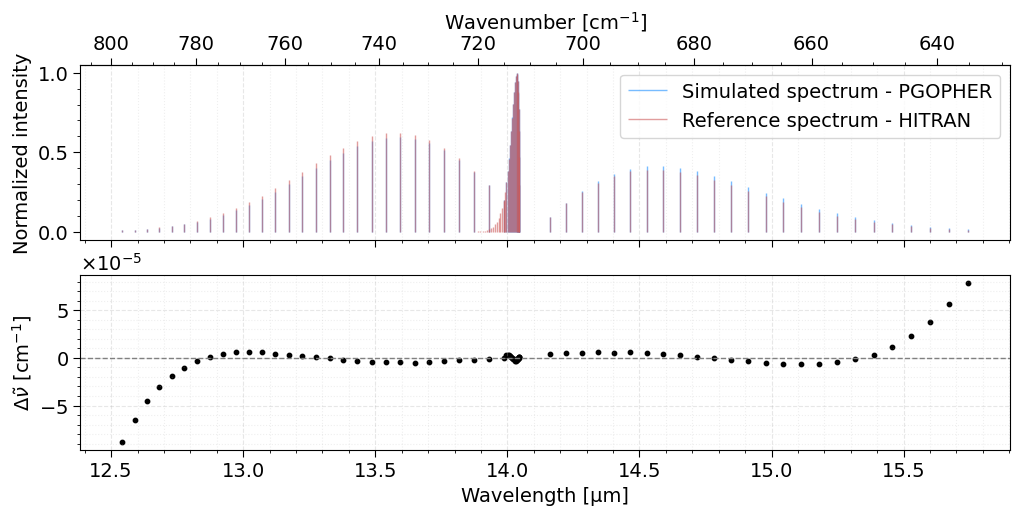

In [22]:
# ---- extract arrays ----
nu_pg  = df_pg["Position"].values
nu_hit = df["nu"].values

# ---- optional wavenumber window ----
nu_min = 635
nu_max = 800

I_pg   = I_pg_norm
I_hit  = I_hit_norm

# ---- build masks safely ----
mask_pg  = np.ones_like(nu_pg, dtype=bool)
mask_hit = np.ones_like(nu_hit, dtype=bool)

if nu_min is not None:
    mask_pg  &= nu_pg  >= nu_min
    mask_hit &= nu_hit >= nu_min

if nu_max is not None:
    mask_pg  &= nu_pg  <= nu_max
    mask_hit &= nu_hit <= nu_max

# ---- apply masks ----
nu_pg_w  = nu_pg[mask_pg]
I_pg_w   = I_pg[mask_pg]

nu_hit_w = nu_hit[mask_hit]
I_hit_w  = I_hit[mask_hit]

# ---- Residuals ----
# ---- build HITRAN lookup: (branch, J'') -> nu ----
hitran_lookup = {
    (row.branch, row.Jpp): row.nu
    for _, row in df.iterrows()
}


# ---- 3) match PGOPHER ↔ HITRAN by quantum numbers ----
nu_pg_m   = []
nu_hit_m  = []
I_pg_m    = []
residuals = []

for _, row in df_pg.iterrows():
    key = (row.branch, row.Jpp)

    if key not in hitran_lookup:
        continue

    nu_hit = hitran_lookup[key]
    nu_pg  = row.Position

    # optional window
    if nu_min is not None and nu_pg < nu_min:
        continue
    if nu_max is not None and nu_pg > nu_max:
        continue

    nu_pg_m.append(nu_pg)
    nu_hit_m.append(nu_hit)
    I_pg_m.append(row.Intensity)
    residuals.append(nu_pg - nu_hit)

nu_pg_m   = np.array(nu_pg_m)
nu_hit_m  = np.array(nu_hit_m)
I_pg_m    = np.array(I_pg_m)
residuals = np.array(residuals)

# ---- convert to wavelength (microns) for plotting ----
lam_pg_w  =  1e4/nu_pg_w
lam_hit_w =  1e4/nu_hit_w

# ---- plotting ----

FS = 14
plt.rcParams.update({
    "font.size": FS,
    "axes.labelsize": FS,
    "axes.titlesize": FS,
    "xtick.labelsize": FS,
    "ytick.labelsize": FS,
    "legend.fontsize": FS,
    "xtick.major.size": FS * 0.35,
    "ytick.major.size": FS * 0.35,
})


plt.figure(figsize=(12, 5))

# top: normalized spectra
ax1 = plt.subplot(2, 1, 1)
ax1.vlines(lam_pg_w, 1e-6, I_pg_w,
           linewidth=1, color="dodgerblue", alpha=0.6, label="Simulated spectrum - PGOPHER")
ax1.vlines(lam_hit_w, 1e-6, I_hit_w,
           linewidth=1, color="indianred", alpha=0.6, label="Reference spectrum - HITRAN")
ax1.set_ylabel("Normalized intensity")
# ax1.set_title("HCN ν₂ Band (normalized)")
ax1.legend()

# hide x tick labels on top axis
ax1.tick_params(labelbottom=False)

# bottom: residuals (shared x-axis)
from matplotlib.ticker import ScalarFormatter

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.scatter(lam_pg_w, residuals, s=10, color="black")
ax2.axhline(0, linestyle="--", color="gray", linewidth=1)

ax2.set_xlabel("Wavelength [µm]")
ax2.set_ylabel(r"$\Delta\tilde{\nu}$ [cm$^{-1}$]")

ax2.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))


# remove vertical gap
plt.subplots_adjust(hspace=0.2)


# ---- dual x-axes: wavelength ↔ wavenumber ----
def nu_to_lam(nu):
    return 1e4 / nu

def lam_to_nu(lam):
    return 1e4 / lam

# Top subplot: add TOP axis = wavenumber
secax1 = ax1.secondary_xaxis(
    "top",
    functions=(lam_to_nu, nu_to_lam)
)
secax1.set_xlabel(r"Wavenumber [cm$^{-1}$]")

from matplotlib.ticker import AutoMinorLocator

# ---- minor ticks ----
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

secax1.xaxis.set_minor_locator(AutoMinorLocator())

# ---- grid (light, publication-style) ----
ax1.grid(True, which="major", axis="x", linestyle="--", alpha=0.3)
ax1.grid(True, which="minor", axis="x", linestyle=":",  alpha=0.2)

ax2.grid(True, which="major", axis="both", linestyle="--", alpha=0.3)
ax2.grid(True, which="minor", axis="both", linestyle=":",  alpha=0.2)

plt.savefig("HCN_v2_PQ_branch_comparison_296K.pdf", bbox_inches="tight")
plt.show()




R(22) wavenumber = 779.726062 cm^-1
R(23) wavenumber = 782.652999 cm^-1


/var/folders/m_/lkkr9ssx3_l8p4_6mmy0fsym0000gn/T/ipykernel_21889/4262272904.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/m_/lkkr9ssx3_l8p4_6mmy0fsym0000gn/T/ipykernel_21889/4262272904.py:50: RuntimeWarning: divide by zero encountered in divide
  return 1e4 / nu
/var/folders/m_/lkkr9ssx3_l8p4_6mmy0fsym0000gn/T/ipykernel_21889/4262272904.py:50: RuntimeWarning: divide by zero encountered in divide
  return 1e4 / nu


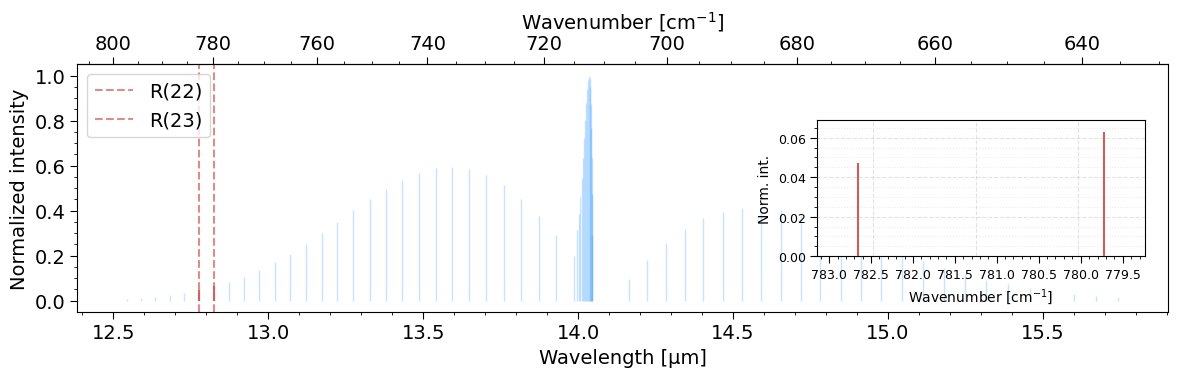

In [23]:
# ---- identify R(22) and R(23) ----
mask_R22_23 = (
    (df_pg["branch"] == "R") &
    (df_pg["Jpp"].isin([22, 23]))
)

nu_R = df_pg.loc[mask_R22_23, "Position"].values
I_R  = I_pg_norm[mask_R22_23.values]

lam_R = 1e4 / nu_R


import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(12, 4))
ax = plt.gca()

# ---- main spectrum (faded) ----
ax.vlines(
    lam_pg_w,
    1e-6,
    I_pg_w,
    linewidth=1,
    color="dodgerblue",
    alpha=0.25
)

# ---- highlight R(22), R(23) ----
ax.vlines(
    lam_R,
    1e-6,
    I_R,
    linewidth=1.5,
    color="indianred",
    alpha=0.9,
)

for _, row in df_pg.loc[mask_R22_23].iterrows():
    print(f"R({row.Jpp}) wavenumber = {row.Position:.6f} cm^-1")
    ax.axvline(1e4 / row.Position, color="indianred", linestyle="--", alpha=0.7, label=f"R({row.Jpp})")

ax.set_xlabel("Wavelength [µm]")
ax.set_ylabel("Normalized intensity")
ax.legend(loc="upper left")

# ---- dual x-axis ----
def nu_to_lam(nu):
    return 1e4 / nu

def lam_to_nu(lam):
    return 1e4 / lam

secax = ax.secondary_xaxis(
    "top",
    functions=(lam_to_nu, nu_to_lam)
)
secax.set_xlabel(r"Wavenumber [cm$^{-1}$]")

# ---- ticks & grid ----
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
secax.xaxis.set_minor_locator(AutoMinorLocator())

# ax.grid(True, which="major", axis="x", linestyle="--", alpha=0.3)
# ax.grid(True, which="minor", axis="x", linestyle=":", alpha=0.2)

# ================= INSET =================
axins = inset_axes(
    ax,
    width="30%",
    height="55%",
    loc="center right",
    borderpad=1.2
)

axins.vlines(
    lam_R,
    1e-6,
    I_R,
    linewidth=1.5,
    color="indianred"
)

pad = 0.008
axins.set_xlim(lam_R.min() - pad, lam_R.max() + pad)
axins.set_ylim(0, I_R.max() * 1.1)

# ---- y-axis only ----
axins.set_ylabel("Norm. int.", fontsize=10)
axins.tick_params(axis="y", which="major", labelsize=9)
axins.yaxis.set_minor_locator(AutoMinorLocator())

# hide wavelength axis
axins.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
axins.spines["bottom"].set_visible(False)

# ---- wavenumber axis at BOTTOM for inset ----
secax_ins = axins.secondary_xaxis(
    "bottom",
    functions=(lam_to_nu, nu_to_lam)
)
secax_ins.set_xlabel(r"Wavenumber [cm$^{-1}$]", fontsize=10)
secax_ins.tick_params(axis="x", labelsize=9)
secax_ins.xaxis.set_minor_locator(AutoMinorLocator())

# ---- grid for inset only ----
axins.grid(True, which="major", linestyle="--", alpha=0.35)
axins.grid(True, which="minor", linestyle=":",  alpha=0.25)


plt.tight_layout()
plt.savefig("HCN_v2_PGOPHER_R22_R23_inset.pdf", bbox_inches="tight")
plt.show()



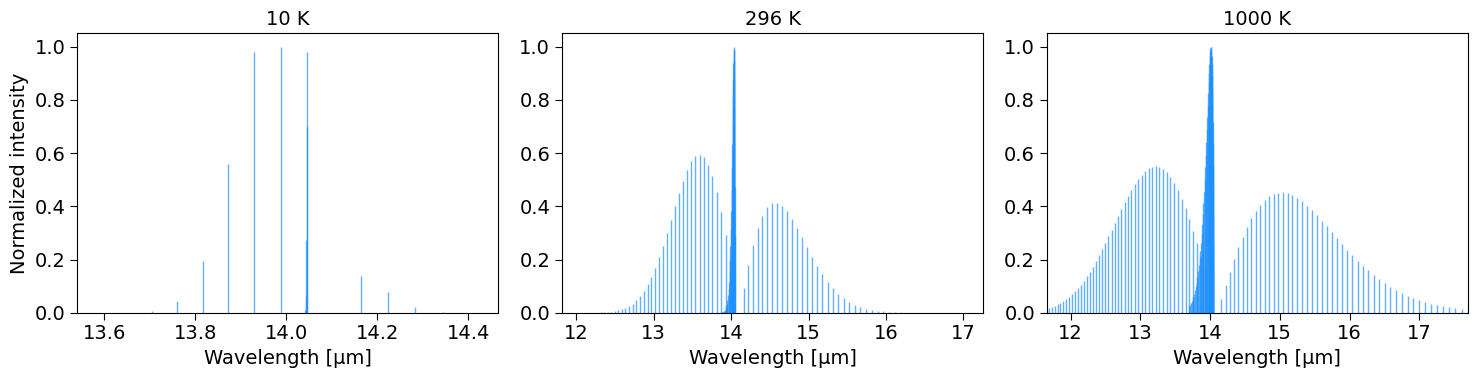

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def read_pgo_spectrum(filename):
    nu = []
    I  = []

    with open(filename) as f:
        for line in f:
            if line.startswith("LinearMolecule"):
                parts = line.split()
                try:
                    nu.append(float(parts[9]))   # Position (cm^-1)
                    I.append(float(parts[10]))  # Intensity
                except (IndexError, ValueError):
                    continue

    nu = np.array(nu)
    I  = np.array(I)

    if len(I) == 0:
        return None, None

    return nu, I / I.max()


files = [
    ("10 K",   "HCN_LinesPQR_10K.txt"),
    ("296 K",  "HCN_LinesPQR_improved.txt"),   # your original file
    ("1000 K", "HCN_LinesPQR_1000K.txt"),
]

plt.figure(figsize=(15, 4))

for i, (label, path) in enumerate(files, start=1):

    nu, I = read_pgo_spectrum(path)
    if nu is None:
        continue

    lam = 1e4 / nu

    ax = plt.subplot(1, 3, i)

    ax.vlines(
        lam,
        1e-6,
        I,
        linewidth=1,
        alpha=0.7,
        color="dodgerblue"
    )

    ax.set_title(label)
    ax.set_xlabel("Wavelength [µm]")

    if i == 1:
        ax.set_ylabel("Normalized intensity")

    ax.set_ylim(0, 1.05)
    ax.set_xlim(lam.min(), lam.max())

plt.tight_layout()
plt.savefig("temperature_dependence.pdf", bbox_inches="tight")
plt.show()


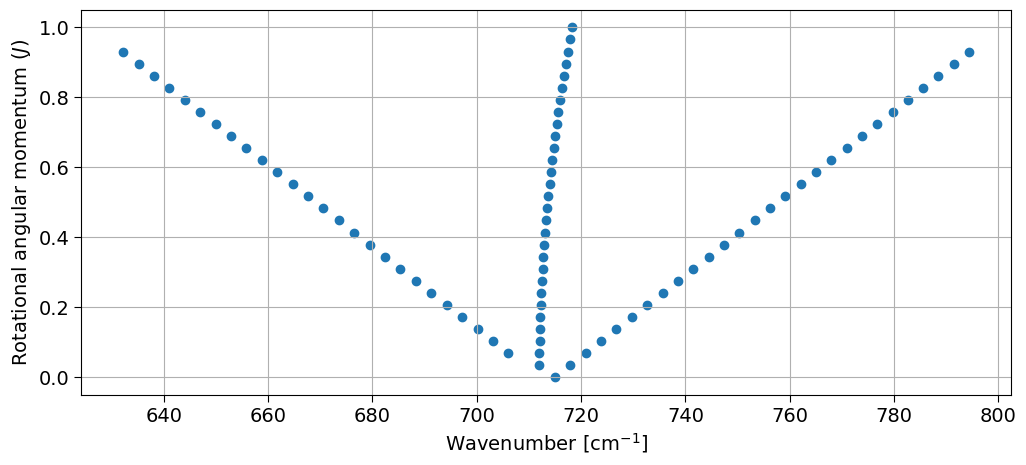

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Load the uploaded data file
file_path = "fortrat_data_final.dat"
data = np.loadtxt(file_path)

# Assume two columns: x and y
x = data[:, 0]
y = data[:, 1]

# Plot
plt.figure(figsize=(12, 5))
plt.scatter(x, y, marker='o')
plt.xlabel(r"Wavenumber [cm$^{-1}$]")
plt.ylabel(r"Rotational angular momentum ($J$)")
plt.grid(True)

plt.savefig("fortrat_plot.pdf", bbox_inches="tight")
plt.show()


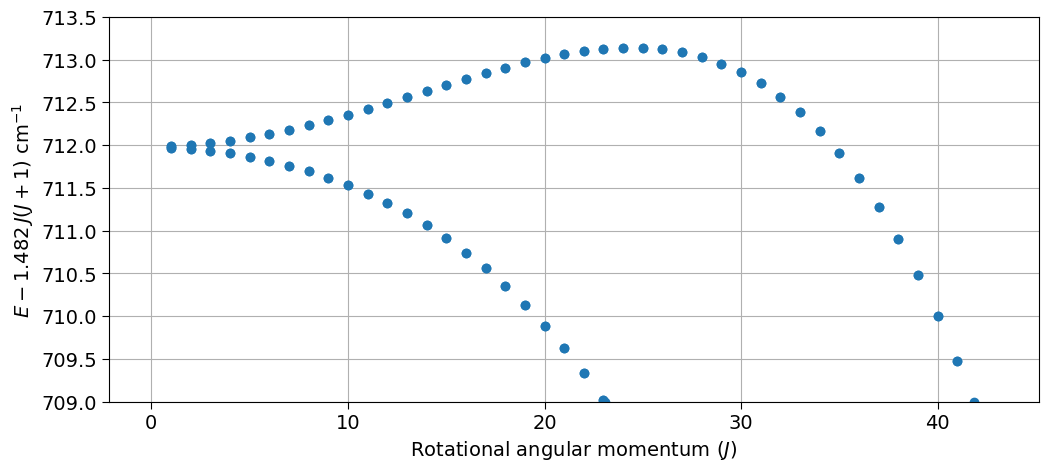

In [26]:

file_path = "energy_level.dat"

# Load only first two columns (quantum number, energy)
data = np.loadtxt(file_path, usecols=(0, 1))

J = data[:, 0]
E = data[:, 1]

# Plot energy levels
plt.figure(figsize=(12, 5))
plt.plot(J, E, marker="o", linestyle="None")
plt.xlabel(r"Rotational angular momentum ($J$)")
plt.ylabel("Energy (arb. units)")
plt.ylabel(
    r"$E - 1.482\,J(J+1)\ \mathrm{cm}^{-1}$"
)
plt.ylim(709, 713.5)
plt.grid(True)


plt.savefig("energy_levels.pdf", bbox_inches="tight")
plt.show()
